# Classify images of clothing

### Import dependencies

In [43]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf 
import tensorflow_datasets as tfds
# tf.logging.set_verbosity(tf.logging.ERROR)

import math 
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tqdm.__version__)

# tf.enable_eager_execution()

4.66.1


### Import fashion mnist dataset

In [44]:
# dataset = tfds.load('fashion_mnist', as_supervised = True)
dataset, metadata = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [45]:
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/home/login/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      autho

In [46]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Explore the data

In [47]:
# basic dataset info
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
metadata.splits['test']

<SplitInfo num_examples=10000, num_shards=1>

### Preprocess the data

In [48]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

### Explore the processed data

2024-02-17 15:22:41.002968: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


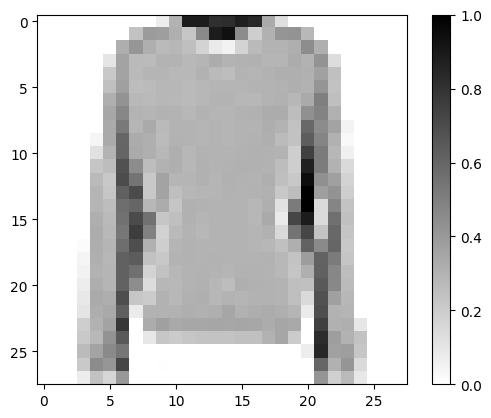

In [49]:
for image, label in train_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

### Visualize more images

2024-02-17 15:22:49.492110: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


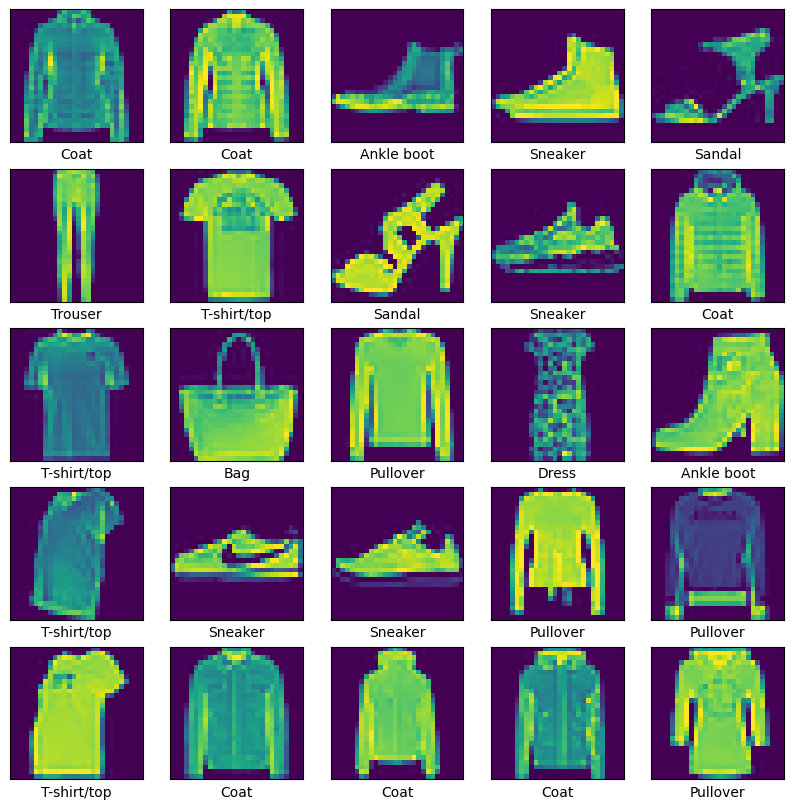

In [51]:
plt.figure(figsize = (10, 10))

for i, (images, labels) in enumerate(test_dataset.take(25)):
    images = images.numpy().reshape((28, 28))
    
    plt.subplot(5, 5, i+1)
    plt.imshow(images)
#     plt.colorbar()
    plt.xlabel(class_names[labels])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

### Build a model

#### Set up the layers

In [53]:
layer2 = tf.keras.layers.Dense(128, activation = tf.nn.relu)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    layer2,
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])

### Compile model

In [54]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
             metrics = ['accuracy'])

### Train the model

In [55]:
BATCH_SIZE = 32
EPOCHS = 5
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset, epochs = EPOCHS, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 11s 4ms/step - loss: 0.4906 - accuracy: 0.8295
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3723 - accuracy: 0.8657
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3305 - accuracy: 0.8790
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3112 - accuracy: 0.8866
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2974 - accuracy: 0.8893


### Evaluate Accuracy

In [56]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps = math.ceil(num_test_examples/32))
print("Accuracy on test dataset: ", test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.3634 - accuracy: 0.8665
Accuracy on test dataset:  0.8665000200271606


### Make predictions and explore

In [57]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

1/1 [==============================] - 0s 168ms/step


In [58]:
predictions.shape

(32, 10)

In [63]:
predictions[1]

array([1.5627396e-06, 2.4383331e-09, 1.0920985e-03, 3.3897113e-08,
       5.6865579e-01, 2.7675051e-11, 4.3024865e-01, 6.8280784e-11,
       1.8769729e-06, 5.3322680e-11], dtype=float32)

In [64]:
np.argmax(predictions[1])

4

In [65]:
test_labels[1]

4

In [66]:
predictions[2]

array([3.7796341e-05, 5.4861706e-09, 4.4503722e-07, 4.5145225e-09,
       1.5904341e-06, 6.7460603e-01, 4.8161432e-06, 5.1916428e-02,
       4.3927412e-06, 2.7342841e-01], dtype=float32)

In [67]:
np.argmax(predictions[2])

5

In [68]:
test_labels[2]

9

### Graph predictions

In [69]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[...,0])
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
              100*np.max(predictions_array),
              class_names[true_label]),
              color = color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color = "#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

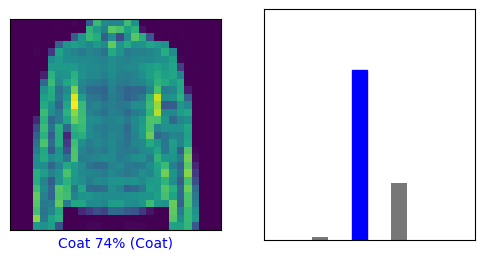

In [70]:
i = 0
plt.figure(figsize = (6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

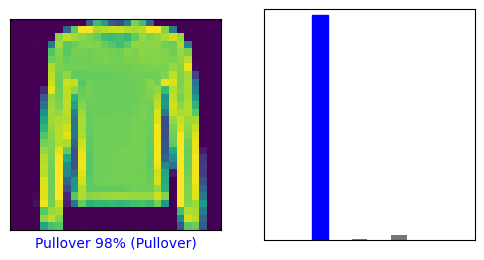

In [72]:
i = 12
plt.figure(figsize = (6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)